In [54]:
# Generating a toy dataset.
# DO NOT MODIFY THIS PART

import numpy as np
import math
import random as rand

paras = list((rand.random() - 0.5 for _ in range(13)))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def y_gen(x):
    h_11 = sigmoid(paras[0] * x[0] + paras[1] * x[1] + paras[2])
    h_12 = sigmoid(paras[3] * x[0] + paras[4] * x[1] + paras[5])
    h_13 = sigmoid(paras[6] * x[0] + paras[7] * x[1] + paras[8])
    h_21 = sigmoid(paras[9] * h_11 + paras[10] * h_12 + paras[11] * h_13 + paras[12])
    return h_21 + ((rand.random()-0.5)/100 if rand.random()>0.6 else 0)

n = 300
x = list(zip((rand.random() - 0.5 for _ in range(n)), (rand.random() - 0.5 for _ in range(n))))
y = list(map(y_gen, x))
y = [(i-min(y))/(max(y)-min(y)) for i in y]

from sklearn.model_selection import train_test_split

r = 0.2
x_train_valid, x_test, y_train_valid, y_test = train_test_split(x, y, test_size=r)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=r)

In [55]:
def initialize_parameters():
    # Layer 1: weights and biases (3 neurons, each with 2 inputs)
    W1 = np.random.uniform(-1, 1, (3, 2))
    b1 = np.zeros((3, 1))

    # Layer 2: weights and biases (1 neuron, with 3 inputs from Layer 1)
    W2 = np.random.uniform(-1, 1, (1, 3))
    b2 = np.zeros((1, 1))

    return W1, b1, W2, b2


In [56]:


def forward_propagation(x, W1, b1, W2, b2):
    Z1 = np.dot(W1, x) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    return A1, A2


In [57]:
def sigmoid_derivative(A):
    return A * (1 - A)

In [58]:
def backward_propagation(x, y, A1, A2, W1, W2):
    # Error at output layer
    dZ2 = A2 - y
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims=True)  # Sum across samples if batched

    # Backpropagate to Layer 1
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * sigmoid_derivative(A1)  # Apply derivative of sigmoid
    dW1 = np.dot(dZ1, x.T)
    db1 = np.sum(dZ1, axis=1, keepdims=True)  # Sum across samples if batched

    return dW1, db1, dW2, db2

In [59]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [60]:
def mse_loss(y_true, y_pred):
    return 0.5 * np.sum((y_true - y_pred) ** 2)

In [61]:
def compute_cost(data, labels, W1, b1, W2, b2):
    total_loss = 0
    n = len(data)  # number of samples
    for x, y in zip(data, labels):
        _, A2 = forward_propagation(np.array(x).reshape(-1, 1), W1, b1, W2, b2)  # Get predictions
        total_loss += mse_loss(y, A2)  # Sum up the loss for each sample

    return total_loss / n  

In [62]:
def train_model(x_train, y_train, x_valid, y_valid, epochs, initial_lr, patience=10):
    W1, b1, W2, b2 = initialize_parameters()
    train_costs = []
    valid_costs = []
    best_loss = float('inf')
    no_improve_epoch = 0
    
    for epoch in range(epochs):
        lr = initial_lr * (0.5 ** (epoch // 50))  # Reduce learning rate every 50 epochs
        
        for x, y in zip(x_train, y_train):
            x_array = np.array(x).reshape(-1, 1)  # Reshape x to column vector
            y_array = np.array(y).reshape(-1, 1)  # Reshape y to column vector
            A1, A2 = forward_propagation(x_array, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward_propagation(x_array, y_array, A1, A2, W1, W2)
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
        
        # Calculate loss for training and validation sets
        train_cost = compute_cost(x_train, y_train, W1, b1, W2, b2)
        valid_cost = compute_cost(x_valid, y_valid, W1, b1, W2, b2)
        train_costs.append(train_cost)
        valid_costs.append(valid_cost)
        
        # Early stopping check
        if valid_cost < best_loss:
            best_loss = valid_cost
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1
        
        if no_improve_epoch >= patience:
            print(f"Stopping early at epoch {epoch}")
            break
        
        # Log progress less frequently
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Training Loss = {train_cost}, Validation Loss = {valid_cost}, Learning Rate = {lr}")

    return W1, b1, W2, b2, train_costs, valid_costs



In [63]:
import matplotlib.pyplot as plt
def plot_costs(train_costs, valid_costs):
    plt.figure(figsize=(10, 5))
    plt.plot(train_costs, label='Training cost')
    plt.plot(valid_costs, label='Validation cost')
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Training and Validation Cost')
    plt.legend()
    plt.show()

In [64]:
import matplotlib.pyplot as plt
def plot_predictions(x_test, y_test, W1, b1, W2, b2):
    predictions = []
    for x in x_test:
        x_array = np.array(x).reshape(-1, 1)
        _, pred = forward_propagation(x_array, W1, b1, W2, b2)
        predictions.append(pred.item())

    plt.figure(figsize=(10, 5))
    plt.scatter([y for y in y_test], predictions, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True and Predicted Outputs')
    plt.show()

Epoch 0: Training Loss = 0.01711368601009254, Validation Loss = 0.018661530316470786, Learning Rate = 0.01
Epoch 10: Training Loss = 0.016422134338639493, Validation Loss = 0.018050709914908883, Learning Rate = 0.01
Epoch 20: Training Loss = 0.015889928257499217, Validation Loss = 0.017376004670500638, Learning Rate = 0.01
Epoch 30: Training Loss = 0.01529829937137961, Validation Loss = 0.01662717507962026, Learning Rate = 0.01
Epoch 40: Training Loss = 0.014601943934902559, Validation Loss = 0.015745750109737108, Learning Rate = 0.01
Epoch 50: Training Loss = 0.013818446811206355, Validation Loss = 0.014751918367607154, Learning Rate = 0.005
Epoch 60: Training Loss = 0.013357490609977325, Validation Loss = 0.014165535414814676, Learning Rate = 0.005
Epoch 70: Training Loss = 0.01286623975228257, Validation Loss = 0.013537471119427949, Learning Rate = 0.005
Epoch 80: Training Loss = 0.012350359907536993, Validation Loss = 0.012874873284136654, Learning Rate = 0.005
Epoch 90: Training L

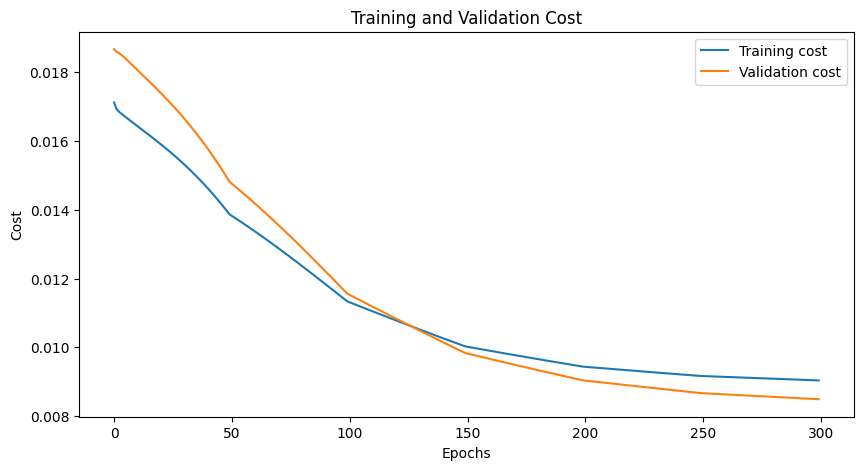

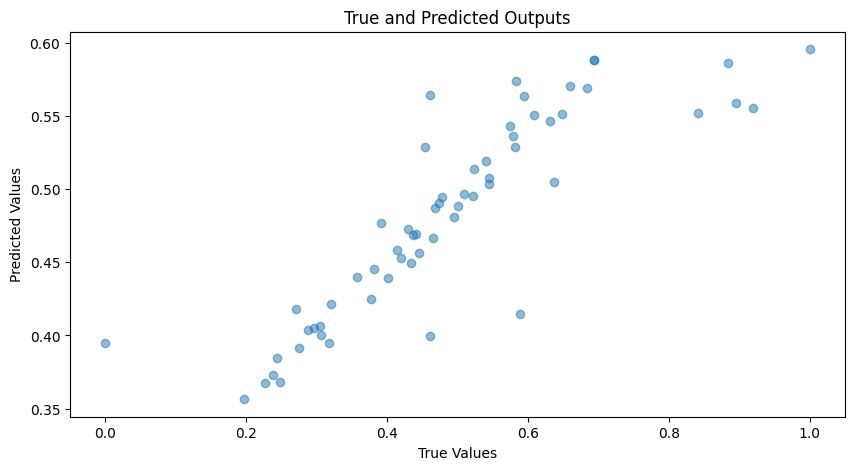

In [65]:
W1, b1, W2, b2, train_costs, valid_costs = train_model(x_train, y_train, x_valid, y_valid, 300, 0.01)
plot_costs(train_costs, valid_costs)
plot_predictions(x_test, y_test, W1, b1, W2, b2)

In [66]:
def regression_accuracy(y_true, y_pred, threshold=0.10):
    """
    Calculate the percentage of predictions within a certain threshold of true values.
    Parameters:
        y_true (numpy.array): True target values.
        y_pred (numpy.array): Predictions made by the model.
        threshold (float): The acceptable threshold as a percentage.
    Returns:
        float: The percentage of predictions within the threshold.
    """
    # Calculate absolute errors in terms of the true values
    errors = np.abs(y_true - y_pred) / np.abs(y_true)
    # Determine which errors are within the acceptable threshold
    accurate_predictions = errors < threshold
    # Calculate the percentage of predictions within the threshold
    accuracy = np.mean(accurate_predictions) * 100
    return accuracy
# Example of training the model
W1, b1, W2, b2, train_costs, valid_costs = train_model(x_train, y_train, x_valid, y_valid, 300, 0.01)

# Generating predictions (let's assume for x_valid for demonstration)
y_pred_valid = [forward_propagation(np.array(x).reshape(-1, 1), W1, b1, W2, b2)[1] for x in x_valid]
y_pred_valid = np.array(y_pred_valid).flatten()  # Flatten to match the shape of y_valid

# Calculate "accuracy"
accuracy = regression_accuracy(np.array(y_valid), y_pred_valid, threshold=0.10)
print(f'Regression Accuracy (within 10% error margin): {accuracy:.2f}%')

    

Epoch 0: Training Loss = 0.01819701587231813, Validation Loss = 0.02021068181245848, Learning Rate = 0.01
Epoch 10: Training Loss = 0.014938016651418898, Validation Loss = 0.016133314016520333, Learning Rate = 0.01
Epoch 20: Training Loss = 0.014180459384851254, Validation Loss = 0.015200821950166867, Learning Rate = 0.01
Epoch 30: Training Loss = 0.013315186643200978, Validation Loss = 0.014123932231682736, Learning Rate = 0.01
Epoch 40: Training Loss = 0.012356042229106303, Validation Loss = 0.0129151056718037, Learning Rate = 0.01
Epoch 50: Training Loss = 0.011399092588687635, Validation Loss = 0.011691912579132007, Learning Rate = 0.005
Epoch 60: Training Loss = 0.010897935124852938, Validation Loss = 0.01104355698640045, Learning Rate = 0.005
Epoch 70: Training Loss = 0.010410137822733175, Validation Loss = 0.010405339000580625, Learning Rate = 0.005
Epoch 80: Training Loss = 0.009944563685096315, Validation Loss = 0.009789135965489857, Learning Rate = 0.005
Epoch 90: Training Lo